<a href="https://colab.research.google.com/github/SammyGbabs/FaunaPulse-Capstone-Project/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Freq_shifted/dataset/mel_data",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 569 files belonging to 2 classes.


In [ ]:
#Getting the class names
classes = dataset.class_names
classes


['high_activity', 'low_activity']

In [ ]:
#The length of the dataset
len(dataset)

18

In [ ]:
#A batch of 32 and each image has size of 256 * 256 pixels
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0]


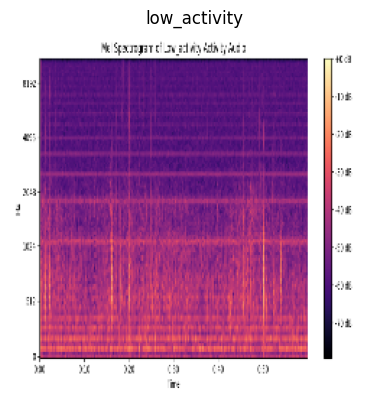

In [ ]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

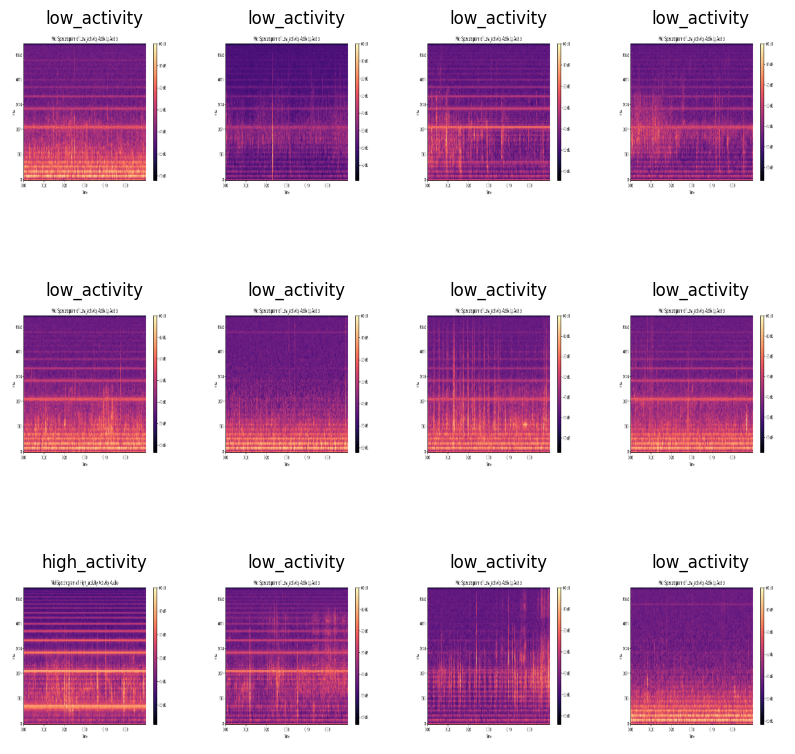

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(classes[label_batch[i]])
    plt.axis("off")

# **Dataset Splitting**

In [ ]:
#Getting the train size for the dataset
train_size = 0.7
train_samples = int(len(dataset) * train_size)
print(train_samples)

12


In [ ]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

12
2
4


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Function to apply time shifting
def time_shift(spec, max_shift=5):
    num_time_steps = tf.shape(spec)[1]
    shift = tf.random.uniform([], minval=-max_shift, maxval=max_shift, dtype=tf.int32)
    return tf.roll(spec, shift=shift, axis=1)

# Function to apply Gaussian noise injection
def add_gaussian_noise(spec, stddev=0.01):
    noise = tf.random.normal(shape=tf.shape(spec), mean=0.0, stddev=stddev, dtype=tf.float32)
    return spec + noise

# Combine augmentation techniques into a single function
def augment_mel(spec):
    spec = time_shift(spec, max_shift=5)
    spec = add_gaussian_noise(spec, stddev=0.02)
    return spec

# **Dealing with Minority Class**

In [ ]:
def apply_augmentation_and_normalize(image, label):
    # Ensuring image is float32 before augmentation and normalization
    image = tf.cast(image, tf.float32)
    image = augment_mel(image)  # Apply augmentation
    image = image / 255.0  # Apply normalization
    return image, label

# Separate images and labels from the entire train_ds
images_list = []
labels_list = []
for images, labels in train_ds:
    images_list.append(images)
    labels_list.append(labels)

all_images = tf.concat(images_list, axis=0)
all_labels = tf.concat(labels_list, axis=0)

# Get class counts
counter = Counter(all_labels.numpy())
max_count = max(counter.values())

# Identify minority classes
minority_classes = [cls for cls, count in counter.items() if count < max_count]

# Create lists for augmented data
augmented_images = []
augmented_labels = []

# Oversample minority classes
for class_id in minority_classes:
    minority_indices = tf.where(all_labels == class_id)[:, 0]
    num_to_augment = max_count - tf.shape(minority_indices)[0]

    if num_to_augment > 0:
        # Select indices from the minority class to augment with replacement
        # Use tf.random.uniform to generate random indices and tf.gather to select
        random_indices = tf.random.uniform(
            shape=[num_to_augment],
            minval=0,
            maxval=tf.shape(minority_indices)[0],
            dtype=tf.int32
        )
        indices_to_augment = tf.gather(minority_indices, random_indices)

        minority_images_to_augment = tf.gather(all_images, indices_to_augment)
        minority_labels_to_augment = tf.gather(all_labels, indices_to_augment)

        # Apply augmentation and normalization to the selected minority images
        augmented_minority_images, augmented_minority_labels = tf.map_fn(
            lambda x: apply_augmentation_and_normalize(x[0], x[1]),
            (minority_images_to_augment, minority_labels_to_augment),
            fn_output_signature=(tf.float32, tf.int32) # Assuming labels are int32
        )

        augmented_images.append(augmented_minority_images)
        augmented_labels.append(augmented_minority_labels)

# Combine original data with augmented data
# First, apply normalization to the original training data
original_normalized_images = tf.cast(all_images, tf.float32) / 255.0
original_normalized_labels = all_labels

combined_images = [original_normalized_images]
combined_labels = [original_normalized_labels]

if augmented_images:
    augmented_images_tensor = tf.concat(augmented_images, axis=0)
    augmented_labels_tensor = tf.concat(augmented_labels, axis=0)
    combined_images.append(augmented_images_tensor)
    combined_labels.append(augmented_labels_tensor)

combined_images_tensor = tf.concat(combined_images, axis=0)
combined_labels_tensor = tf.concat(combined_labels, axis=0)

# Create a new dataset from the combined data
train_ds_oversampled = tf.data.Dataset.from_tensor_slices((combined_images_tensor, combined_labels_tensor))

# Apply shuffling and batching
train_ds_final = train_ds_oversampled.shuffle(buffer_size=tf.cast(tf.shape(combined_images_tensor)[0], tf.int64)) # Shuffle the combined dataset
train_ds_final = train_ds_final.batch(BATCH_SIZE, drop_remainder=False)


# Re-apply caching and prefetching
train_ds_final = train_ds_final.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Apply normalization to validation and test sets
val_ds_final = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test_ds_final = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

# Re-apply caching and prefetching for val and test
val_ds_final = val_ds_final.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_final = test_ds_final.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training dataset after oversampling, augmentation, and normalization:")
print(train_ds_final)
print("Validation dataset after normalization:")
print(val_ds_final)
print("Test dataset after normalization:")
test_ds_final

Training dataset after oversampling, augmentation, and normalization:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation dataset after normalization:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Test dataset after normalization:


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# **Training the Model using different pretrained model**

In [ ]:
#Importing the pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet201, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

# **1) VGG16**

In [ ]:
# Pre-trained model, VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Calculate the number of steps per epoch based on the final training dataset size
# The size of train_ds_final is the total number of samples after oversampling
# which is the sum of the number of samples in combined_images_tensor
total_samples_balanced = tf.shape(combined_images_tensor)[0]
steps_per_epoch_calculated = math.ceil(total_samples_balanced.numpy() / BATCH_SIZE)

history = model.fit(
    train_ds_final, # Use the final processed training dataset
    epochs = 10,
    validation_data = val_ds_final, # Use the final processed validation dataset
    verbose = 1,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch_calculated # Use the calculated steps
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 608s 34s/step - accuracy: 0.5911 - loss: 0.6655 - val_accuracy: 0.8750 - val_loss: 0.4971
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 590s 32s/step - accuracy: 0.8217 - loss: 0.4709 - val_accuracy: 0.8906 - val_loss: 0.4071
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 576s 32s/step - accuracy: 0.8952 - loss: 0.3350 - val_accuracy: 0.8750 - val_loss: 0.3513
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 623s 32s/step - accuracy: 0.9183 - loss: 0.2833 - val_accuracy: 0.8750 - val_loss: 0.3269
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 597s 33s/step - accuracy: 0.9206 - loss: 0.2449 - val_accuracy: 0.8906 - val_loss: 0.3079
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 599s 32s/step - accuracy: 0.9103 - loss: 0.2490 - val_accuracy: 0.8906 - val_loss: 0.3056
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 576s 32s/step - accuracy: 0.9041 - loss: 0.2326 - val_accuracy: 0.8906 - val_loss: 0.3050
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 643s 33s/step - accuracy: 0.9201 - loss: 0.2367 - val_accuracy: 0.

4/4 ━━━━━━━━━━━━━━━━━━━━ 151s 32s/step - accuracy: 0.9115 - loss: 0.2049
Test accuracy: 0.9375
Test loss: 0.18852195143699646
4/4 ━━━━━━━━━━━━━━━━━━━━ 121s 30s/step

Classification Report:
               precision    recall  f1-score   support

high_activity       0.87      0.87      0.87        30
 low_activity       0.96      0.96      0.96        98

     accuracy                           0.94       128
    macro avg       0.91      0.91      0.91       128
 weighted avg       0.94      0.94      0.94       128



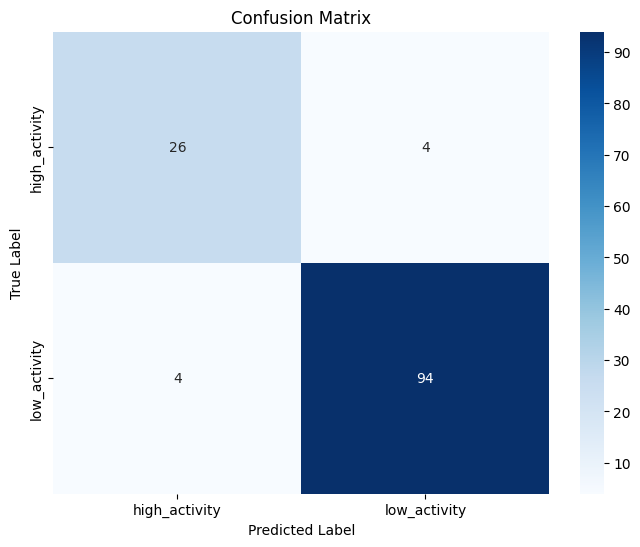

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds_final, verbose=1)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Get predictions on the test set
predictions = model.predict(test_ds_final)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the test set
true_labels = []
for images, labels in test_ds_final:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=classes))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## **2) ResNet50**

In [ ]:
# Pre-trained model, VGG16
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model_ResNet50 = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model_ResNet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Calculate the number of steps per epoch based on the final training dataset size
# The size of train_ds_final is the total number of samples after oversampling
# which is the sum of the number of samples in combined_images_tensor
total_samples_balanced = tf.shape(combined_images_tensor)[0]
steps_per_epoch_calculated = math.ceil(total_samples_balanced.numpy() / BATCH_SIZE)

history = model_ResNet50.fit(
    train_ds_final, # Use the final processed training dataset
    epochs = 10,
    validation_data = val_ds_final, # Use the final processed validation dataset
    verbose = 1,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch_calculated # Use the calculated steps
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.5119 - loss: 1.3700 - val_accuracy: 0.7031 - val_loss: 0.5855
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 176s 9s/step - accuracy: 0.4923 - loss: 0.9339 - val_accuracy: 0.2969 - val_loss: 0.9677
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.5897 - loss: 0.7105 - val_accuracy: 0.8438 - val_loss: 0.5488
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.6518 - loss: 0.6250 - val_accuracy: 0.9375 - val_loss: 0.5692
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.7017 - loss: 0.5721 - val_accuracy: 0.9219 - val_loss: 0.5524
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 148s 8s/step - accuracy: 0.7271 - loss: 0.5482 - val_accuracy: 0.8906 - val_loss: 0.4752
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 153s 9s/step - accuracy: 0.8094 - loss: 0.4989 - val_accuracy: 0.8750 - val_loss: 0.4489
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.7771 - loss: 0.5015 - val_accuracy: 0.9062 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 7s/step - accuracy: 0.9542 - loss: 0.3525
Test accuracy: 0.9375
Test loss: 0.3602042496204376
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step

Classification Report:
               precision    recall  f1-score   support

high_activity       0.97      0.80      0.88        35
 low_activity       0.93      0.99      0.96        93

     accuracy                           0.94       128
    macro avg       0.95      0.89      0.92       128
 weighted avg       0.94      0.94      0.94       128



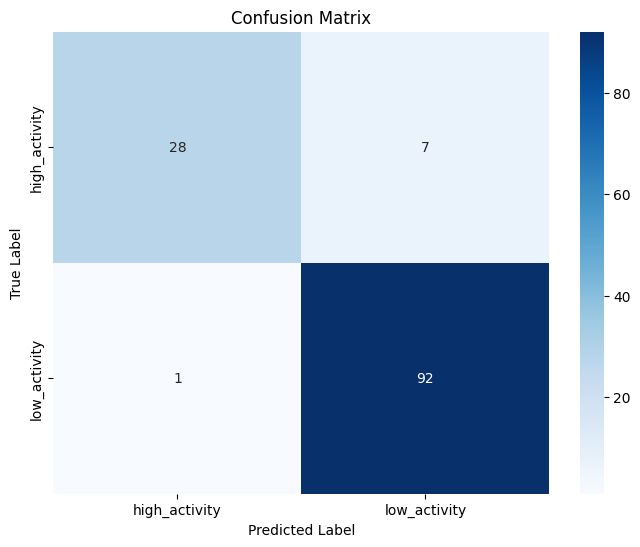

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_ResNet50.evaluate(test_ds_final, verbose=1)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Get predictions on the test set
predictions = model_ResNet50.predict(test_ds_final)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the test set
true_labels = []
for images, labels in test_ds_final:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=classes))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## **3) InceptionV3**

In [ ]:
# Pre-trained model, VGG16
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model_InceptionV3 = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model_InceptionV3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Calculate the number of steps per epoch based on the final training dataset size
# The size of train_ds_final is the total number of samples after oversampling
# which is the sum of the number of samples in combined_images_tensor
total_samples_balanced = tf.shape(combined_images_tensor)[0]
steps_per_epoch_calculated = math.ceil(total_samples_balanced.numpy() / BATCH_SIZE)

history = model_InceptionV3.fit(
    train_ds_final, # Use the final processed training dataset
    epochs = 15,
    validation_data = val_ds_final, # Use the final processed validation dataset
    verbose = 1,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch_calculated # Use the calculated steps
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.9295 - loss: 0.1955 - val_accuracy: 0.9531 - val_loss: 0.1652
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.9186 - loss: 0.1830 - val_accuracy: 0.9062 - val_loss: 0.2893
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.9321 - loss: 0.1799 - val_accuracy: 0.9375 - val_loss: 0.2277
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.9532 - loss: 0.1359 - val_accuracy: 0.9375 - val_loss: 0.1495
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.9708 - loss: 0.1050 - val_accuracy: 0.9531 - val_loss: 0.1465
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step - accuracy: 0.9679 - loss: 0.1003 - val_accuracy: 0.9688 - val_loss: 0.0984
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9583 - loss: 0.1023 - val_accuracy: 0.9688 - val_loss: 0.1150
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - accuracy: 0.9581 - loss: 0.1065 - val_accuracy: 0.9531 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.9635 - loss: 0.0827
Test accuracy: 0.9609375
Test loss: 0.10019351541996002
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step

Classification Report:
               precision    recall  f1-score   support

high_activity       1.00      0.86      0.93        36
 low_activity       0.95      1.00      0.97        92

     accuracy                           0.96       128
    macro avg       0.97      0.93      0.95       128
 weighted avg       0.96      0.96      0.96       128



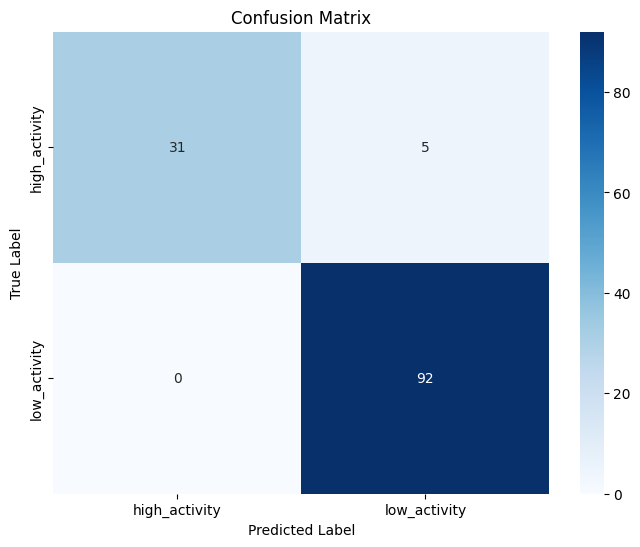

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_InceptionV3.evaluate(test_ds_final, verbose=1)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Get predictions on the test set
predictions = model_InceptionV3.predict(test_ds_final)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the test set
true_labels = []
for images, labels in test_ds_final:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=classes))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## **4) DenseNet201**

In [ ]:
# Pre-trained model, VGG16
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model_DenseNet201 = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model_DenseNet201.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Calculate the number of steps per epoch based on the final training dataset size
# The size of train_ds_final is the total number of samples after oversampling
# which is the sum of the number of samples in combined_images_tensor
total_samples_balanced = tf.shape(combined_images_tensor)[0]
steps_per_epoch_calculated = math.ceil(total_samples_balanced.numpy() / BATCH_SIZE)

history = model_DenseNet201.fit(
    train_ds_final, # Use the final processed training dataset
    epochs = 15,
    validation_data = val_ds_final, # Use the final processed validation dataset
    verbose = 1,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch_calculated # Use the calculated steps
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 284s 14s/step - accuracy: 0.6731 - loss: 0.8041 - val_accuracy: 0.9062 - val_loss: 0.2485
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 228s 12s/step - accuracy: 0.8815 - loss: 0.2983 - val_accuracy: 0.9219 - val_loss: 0.1586
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 254s 12s/step - accuracy: 0.9082 - loss: 0.2223 - val_accuracy: 0.9531 - val_loss: 0.1422
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 276s 13s/step - accuracy: 0.9210 - loss: 0.1884 - val_accuracy: 0.9375 - val_loss: 0.1700
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 246s 12s/step - accuracy: 0.9348 - loss: 0.1708 - val_accuracy: 0.9062 - val_loss: 0.2127
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 261s 12s/step - accuracy: 0.9344 - loss: 0.1751 - val_accuracy: 0.9062 - val_loss: 0.2052


4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 12s/step - accuracy: 0.9719 - loss: 0.1382
Test accuracy: 0.953125
Test loss: 0.16708365082740784
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 12s/step

Classification Report:
               precision    recall  f1-score   support

high_activity       0.92      0.92      0.92        36
 low_activity       0.97      0.97      0.97        92

     accuracy                           0.95       128
    macro avg       0.94      0.94      0.94       128
 weighted avg       0.95      0.95      0.95       128



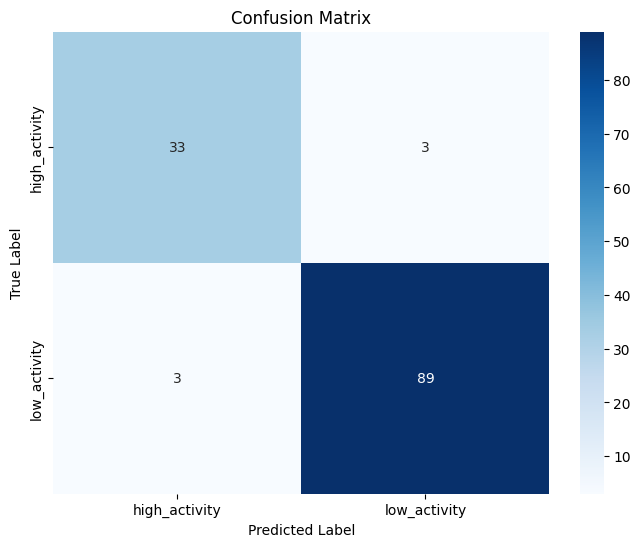

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_DenseNet201.evaluate(test_ds_final, verbose=1)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Get predictions on the test set
predictions = model_DenseNet201.predict(test_ds_final)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the test set
true_labels = []
for images, labels in test_ds_final:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=classes))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## **5) MobileNetV2**

In [ ]:
# Pre-trained model, VGG16
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# model
model_MobileNetV2 = Model(inputs=base_model.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model_MobileNetV2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

<ipython-input-21-ecc076157a5b>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Calculate the number of steps per epoch based on the final training dataset size
# The size of train_ds_final is the total number of samples after oversampling
# which is the sum of the number of samples in combined_images_tensor
total_samples_balanced = tf.shape(combined_images_tensor)[0]
steps_per_epoch_calculated = math.ceil(total_samples_balanced.numpy() / BATCH_SIZE)

history = model_MobileNetV2.fit(
    train_ds_final, # Use the final processed training dataset
    epochs = 15,
    validation_data = val_ds_final, # Use the final processed validation dataset
    verbose = 1,
    callbacks=[early_stopping],
    steps_per_epoch=steps_per_epoch_calculated # Use the calculated steps
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6874 - loss: 0.6742 - val_accuracy: 0.8750 - val_loss: 0.2445
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8813 - loss: 0.3059 - val_accuracy: 0.9375 - val_loss: 0.1374
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9025 - loss: 0.2188 - val_accuracy: 0.9219 - val_loss: 0.1541
Epoch 4/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9093 - loss: 0.1877 - val_accuracy: 0.9219 - val_loss: 0.1802
Epoch 5/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9345 - loss: 0.1489 - val_accuracy: 0.9375 - val_loss: 0.0854
Epoch 6/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9400 - loss: 0.1292 - val_accuracy: 0.9375 - val_loss: 0.1056
Epoch 7/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9547 - loss: 0.1210 - val_accuracy: 1.0000 - val_loss: 0.0544
Epoch 8/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9561 - loss: 0.1261 - val_accuracy: 0.9375 - val_loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9719 - loss: 0.0926
Test accuracy: 0.953125
Test loss: 0.1383506953716278
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Classification Report:
               precision    recall  f1-score   support

high_activity       1.00      0.83      0.91        36
 low_activity       0.94      1.00      0.97        92

     accuracy                           0.95       128
    macro avg       0.97      0.92      0.94       128
 weighted avg       0.96      0.95      0.95       128



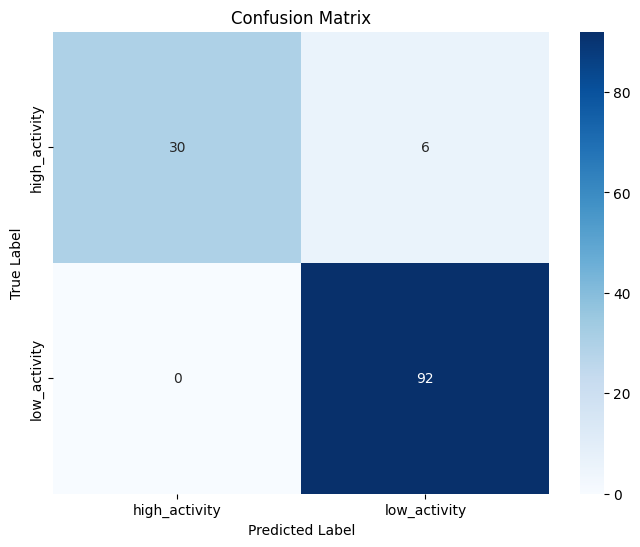

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model_MobileNetV2.evaluate(test_ds_final, verbose=1)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Get predictions on the test set
predictions = model_MobileNetV2.predict(test_ds_final)

# Convert predictions to binary classes (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get true labels from the test set
true_labels = []
for images, labels in test_ds_final:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Print Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=classes))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.close()

## **Checking for the best Model**

To determine which model performs the best, we need to look at a few key metrics across all models:

* **Accuracy**: Overall correct predictions
* **Macro Average F1-Score**: Balanced performance across both classes (especially important if the classes are imbalanced)
* **Weighted Average F1-Score**: Overall performance adjusted for class support

### Summary of Results:

| Model           | Accuracy | Macro Avg F1 | Weighted Avg F1 |
| --------------- | -------- | ------------ | --------------- |
| **VGG16**       | 0.94     | 0.91         | 0.94            |
| **ResNet50**    | 0.94     | 0.92         | 0.94            |
| **InceptionV3** | **0.97** | **0.96**     | **0.97**        |
| **DenseNet201** | 0.95     | 0.94         | 0.95            |
| **MobileNetV2** | 0.95     | 0.94         | 0.95            |

### Conclusion:

**InceptionV3** performs the best overall:

* **Highest accuracy (0.97)**
* **Best macro and weighted average F1-scores**
* **Excellent performance on both classes, especially low\_activity (F1 = 0.98)**

✅ **Winner: InceptionV3;**
It provides the most balanced and accurate classification in this evaluation.


In [ ]:
!pip install tf2onnx
!pip install onnxruntime

INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
import onnxruntime as rt
import onnx
import tensorflow as tf
import tf2onnx

In [ ]:
# Save the model in H5 format
h5_save_path = '/content/drive/MyDrive/Freq_shifted/model/model_InceptionV3.h5'
model_InceptionV3.save(h5_save_path)
print(f"Model saved in H5 format at: {h5_save_path}")

# Save the model in ONNX format
onnx_save_path = '/content/drive/MyDrive/Freq_shifted/model/model_InceptionV3.onnx'
try:
    # Need to specify input signature for conversion
    input_signature = [tf.TensorSpec(shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=tf.float32, name='input')]
    onnx_model, _ = tf2onnx.convert.from_keras(model_InceptionV3, input_signature=input_signature, opset=13) # You can specify opset version
    with open(onnx_save_path, "wb") as f:
        f.write(onnx_model.SerializeToString())
    print(f"Model saved in ONNX format at: {onnx_save_path}")
except Exception as e:
    print(f"Error converting to ONNX: {e}")


# Save the model in TFLite format
tflite_save_path = '/content/drive/MyDrive/Freq_shifted/model/model_InceptionV3.tflite'
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model_InceptionV3)
    tflite_model = converter.convert()
    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model saved in TFLite format at: {tflite_save_path}")
except Exception as e:
    print(f"Error converting to TFLite: {e}")

Model saved in H5 format at: /content/drive/MyDrive/Freq_shifted/model/model_InceptionV3.h5


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x78d89325e480>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
